# CS421 Project: Appendix (Exploratory Data Analysis)
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

In this notebook, we explore statistics related to the dataset, and determine which additional features to create in order to create better prediction models.

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress FutureWarnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the Seaborn style
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Load the data
first_batch  = np.load("data/Week1/first_batch_regression_labelled.npz")
second_batch  = np.load("data/Week2/second_batch_regression_labelled.npz")
third_batch  = np.load("data/Week3/third_batch_regression_labelled.npz")

# Extract X, y, y_cat for each batch
X1, y1, y1_cat = first_batch["X"], first_batch["yy"], first_batch["yy_cat"]
X2, y2, y2_cat = second_batch["X"], second_batch["yy"], second_batch["yy_cat"]
X3, y3, y3_cat = third_batch["X"], third_batch["yy"], third_batch["yy_cat"]

# Convert to DataFrames and rename columns for each batch
X1     = pd.DataFrame(X1, columns=["user", "item", "rating"])
y1     = pd.DataFrame(y1, columns=["user", "label"])
y1_cat = pd.DataFrame(y1_cat, columns=["user", "label", "anomtype"])
X2     = pd.DataFrame(X2, columns=["user", "item", "rating"])
y2     = pd.DataFrame(y2, columns=["user", "label"])
y2_cat = pd.DataFrame(y2_cat, columns=["user", "label", "anomtype"])
X3     = pd.DataFrame(X3, columns=["user", "item", "rating"])
y3     = pd.DataFrame(y3, columns=["user", "label"])
y3_cat = pd.DataFrame(y3_cat, columns=["user", "label", "anomtype"])

# Add a 'batch' column to identify each batch
X1['batch'] = 'Week 1'
X2['batch'] = 'Week 2'
X3['batch'] = 'Week 3'

# Combine the data for easier plotting
X_combined = pd.concat([X1, X2, X3], ignore_index=True)
y_combined = pd.concat([y1, y2, y3], ignore_index=True)
y_cat_combined = pd.concat([y1_cat, y2_cat, y3_cat], ignore_index=True)

# Parse to correct types
y_combined     = y_combined.astype({"user": int, "label": float})
y_cat_combined = y_cat_combined.astype({"user": int, "label": float, "anomtype": int})

In [3]:
# We found that there are quite a few duplicates (i.e. a user rated an item more than once)
# We assume that a user's final rating is the final decision, and we keep that
# To check if this affects accuracy

X_no_dupes = X_combined.drop_duplicates(subset=["user", "item"], keep="last")

print(X_no_dupes.shape)

(784964, 4)


In [4]:
X_no_dupes

,user,item,rating,batch
0,0,94,2,Week 1
1,0,90,1,Week 1
2,0,97,2,Week 1
3,0,100,4,Week 1
4,0,101,2,Week 1
...,...,...,...,...
857547,2699,295,1,Week 3
857548,2699,280,3,Week 3
857549,2699,542,0,Week 3
857550,2699,870,0,Week 3


In [5]:
X_no_dupes["rating"].value_counts()

rating
4    275785
3    226459
2    107255
5    107198
1     60242
0      8025
Name: count, dtype: int64

### Mean ratings and rating percentages
Firstly, we hypothesized that the different anomtypes may have noise that skew the datapoints to have different means and rating percentages, so we decided to plot some graphs to check it out.

,user,mean_rating,label,anomtype,group
0,0,2.435644,NaN,NaN,Unknown anomtype
1,1,2.698507,NaN,NaN,Unknown anomtype
2,2,3.904580,NaN,NaN,Unknown anomtype
3,3,3.801370,NaN,NaN,Unknown anomtype
4,4,4.373737,NaN,NaN,Unknown anomtype
...,...,...,...,...,...
2695,2695,3.697674,NaN,NaN,Unknown anomtype
2696,2696,3.454976,NaN,NaN,Unknown anomtype
2697,2697,3.439252,NaN,NaN,Unknown anomtype
2698,2698,4.301587,NaN,NaN,Unknown anomtype


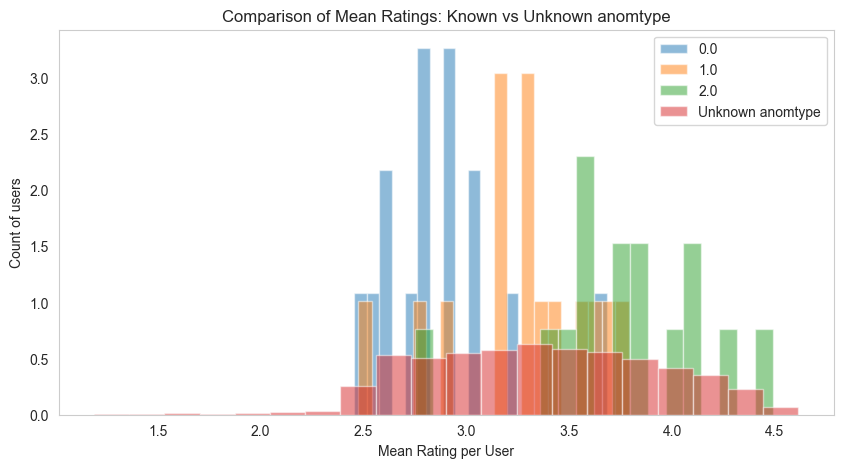

In [6]:
# Comparison of Mean Ratings: Known vs Unknown anomtype

# Step 1: compute mean rating per user from X
user_means = X_no_dupes.groupby("user")["rating"].mean().reset_index(name="mean_rating")

# Step 2: join with anomtype info
user_means = user_means.merge(y_cat_combined, on="user", how="left")

# Step 3: create a "group" column (known vs unknown anomtype)
user_means["group"] = user_means["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

display(user_means)

plt.figure(figsize=(10, 5))
for group, data in user_means.groupby("group"):
    plt.hist(
        data["mean_rating"], 
        bins=20,
        alpha=0.5,
        density=True,
        label=group)

plt.xlabel("Mean Rating per User")
plt.ylabel("Count of users")
plt.title("Comparison of Mean Ratings: Known vs Unknown anomtype")
plt.legend()
plt.grid()
plt.show()

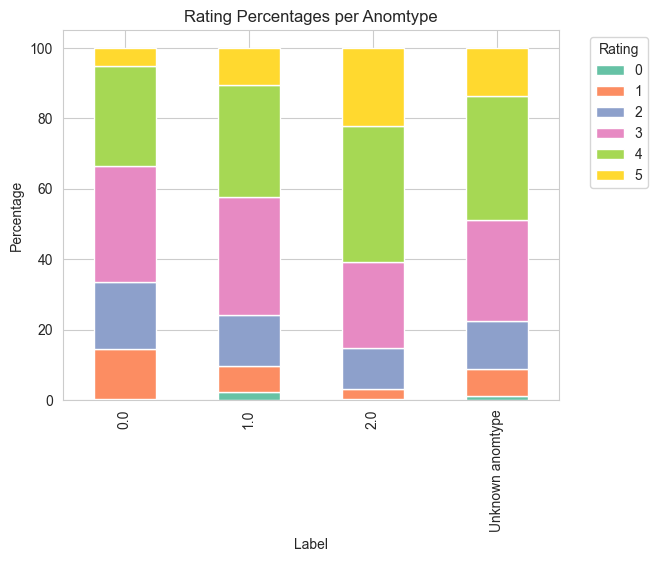

In [7]:
# Rating Percentages per Anomtype

merged_df = pd.merge(X_no_dupes, y_cat_combined, on='user', how='left')
merged_df["anomtype"] = merged_df["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

rating_counts = merged_df.groupby(['anomtype', 'rating']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Rating Percentages per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

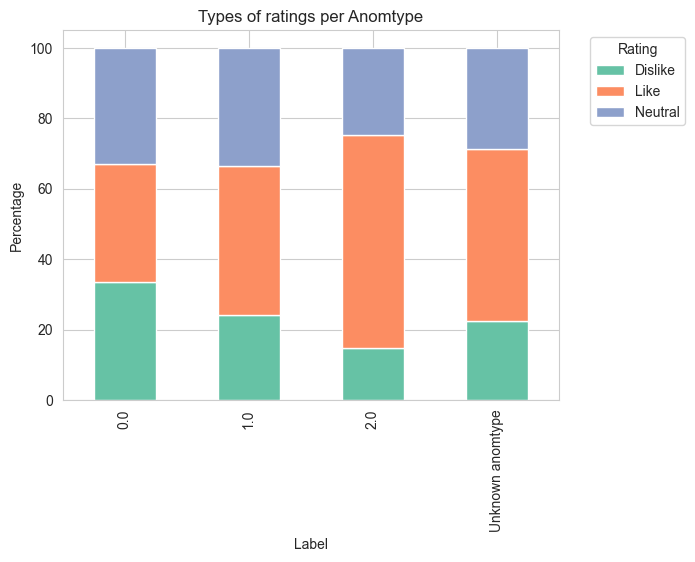

In [8]:
# We now group the ratings into categories of Dislike/Neutral/Like

def map_rating_category(r):
    if r in [0, 1, 2]:
        return "Dislike"
    elif r == 3:
        return "Neutral"
    else: 
        return "Like"

merged_df["rating_category"] = merged_df["rating"].apply(map_rating_category)

rating_counts = merged_df.groupby(['anomtype', 'rating_category']).size().unstack(fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentages.plot(kind='bar', stacked=True, ax=plt.gca(), color=sns.color_palette('Set2'))
plt.title('Types of ratings per Anomtype')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1))

Our hypothesis seems to be true: it is evident from this graph that the different labels have different mean ratings and rating percentages. For example, anomtype 0 has quite a small like percentage compared to that of anomtype 2. 
This suggests the need to create additional features such as mean_rating and possibly like_ratio/dislike_ratio/neutral_ratio for our models to more accurately predict the anomtype.

### Creating Basic Features

In [9]:
# Basic user features
df_user_features = X_no_dupes.groupby("user").agg(
    mean_rating=("rating", "mean"),
    median_rating=("rating", "median"),
    std_rating=("rating", "std"),
    count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
    count_neutral=("rating", lambda x: (x == 3).sum()),
    count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
    total_interactions=("rating", "count"),
)


display(df_user_features)

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions
user,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202
1,2.698507,3.0,0.838000,138,154,43,335
2,3.904580,4.0,0.576070,1,54,207,262
3,3.801370,4.0,1.084853,35,50,207,292
4,4.373737,4.0,0.713693,7,6,185,198
...,...,...,...,...,...,...,...
2695,3.697674,4.0,1.162797,34,39,142,215
2696,3.454976,4.0,0.851671,24,81,106,211
2697,3.439252,4.0,1.202946,65,77,179,321


### Ratio Features

Text(0, 0.5, 'Frequency')

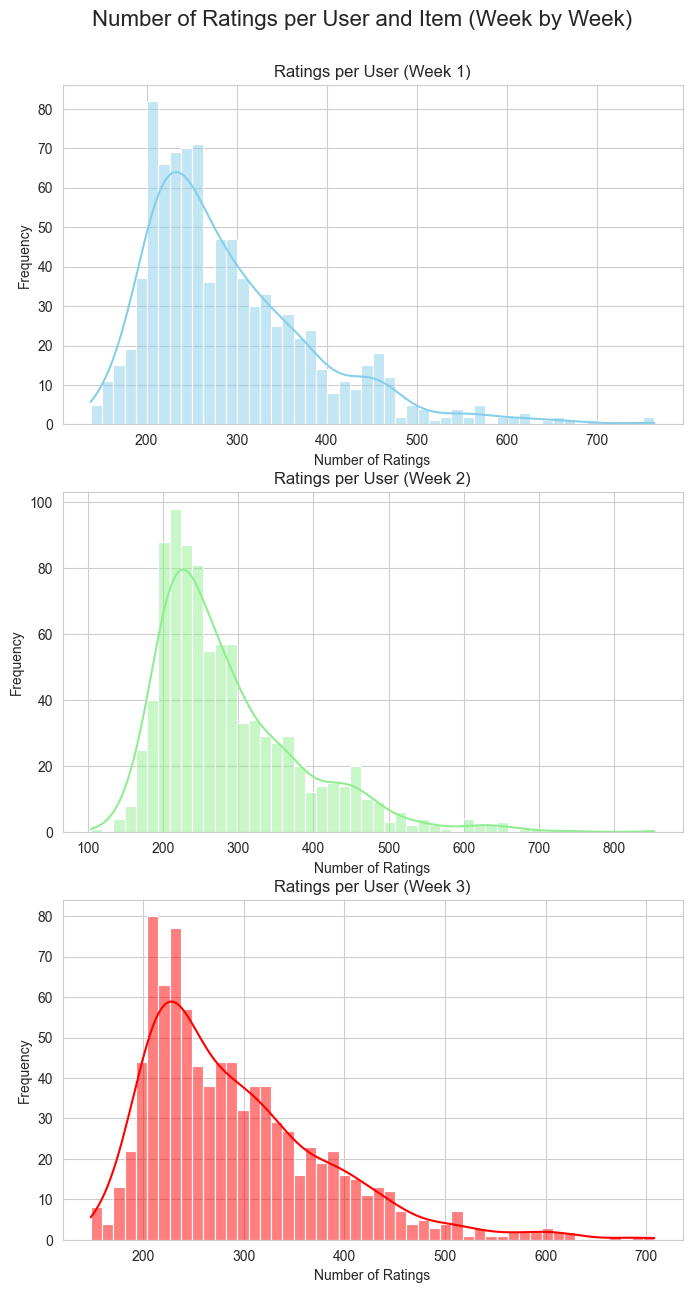

In [29]:
# Number of Ratings per User

user_ratings = X_no_dupes.groupby(['batch', 'user']).size().reset_index(name='rating_count')
item_ratings = X_no_dupes.groupby(['batch', 'item']).size().reset_index(name='rating_count')

# sns.histplot(data=user_ratings, x='rating_count', bins=50, kde=True, color='skyblue')
# plt.title('Ratings per User')
# plt.xlabel('Number of Ratings')
# plt.ylabel('Frequency')

# plt.show()

# Create the second dashboard with a 3x1 grid
fig2 = plt.figure(figsize=(8, 15))
fig2.suptitle("Number of Ratings per User and Item (Week by Week)", fontsize=16, y=0.93)

# Week 1
plt.subplot(3, 1, 1)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 1'], x='rating_count', bins=50, kde=True, color='skyblue')
plt.title('Ratings per User (Week 1)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Week 2
plt.subplot(3, 1, 2)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 2'], x='rating_count', bins=50, kde=True, color='lightgreen')
plt.title('Ratings per User (Week 2)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

# Week 3
plt.subplot(3, 1, 3)
sns.histplot(data=user_ratings[user_ratings['batch'] == 'Week 3'], x='rating_count', bins=50, kde=True, color='red')
plt.title('Ratings per User (Week 3)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')

A skewed distribution (many users with few interactions, few with many) further suggests that we need to create additional features such as ratios (like_ratio, dislike_ratio) to account for varying activity levels.

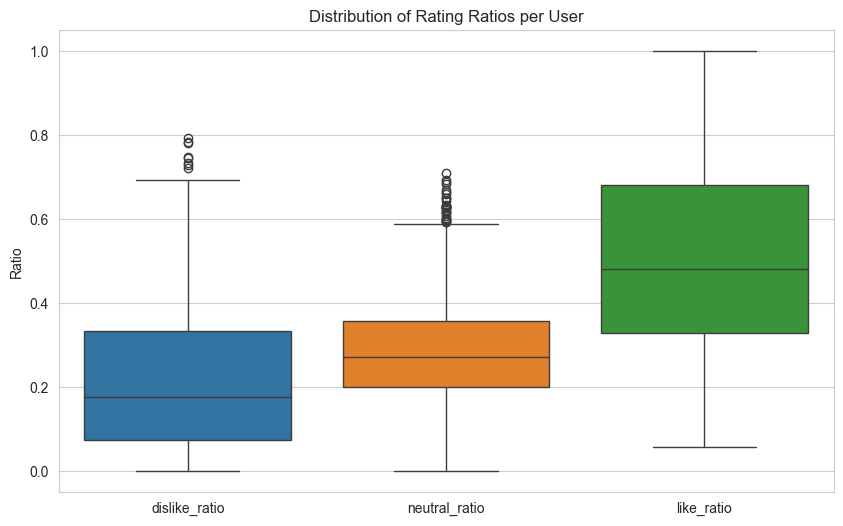

In [30]:
# Calculate counts per user for specific ratings
user_rating_counts = X_no_dupes.groupby('user')['rating'].agg(
    dislike=lambda x: ((x == 0) | (x == 1) | (x == 2)).sum(),
    neutral=lambda x: (x == 3).sum(),
    like=lambda x: ((x == 4) | (x == 5)).sum()
).reset_index()

# Calculate ratios (relative to total interactions)
user_total = X_no_dupes.groupby('user')['rating'].count().reset_index(name='total')
user_rating_ratios = pd.merge(user_rating_counts, user_total, on='user')
for col in ['dislike', 'neutral', 'like']:
    user_rating_ratios[f'{col}_ratio'] = user_rating_ratios[col] / user_rating_ratios['total']

# Boxplot of ratios
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_rating_ratios[['dislike_ratio', 'neutral_ratio', 'like_ratio']])
plt.title('Distribution of Rating Ratios per User')
plt.ylabel('Ratio')
plt.show()

There are an extreme number of outliers in both dislike_ratio and neutral_ratio which suggests they capture distinctive user patterns. If these extreme values correspond to meaningful class differences (anomtype), including this feature could help reduce the Bayes risk and improve accuracy.

### Creating Ratio Features

In [31]:
df_user_features["like_ratio"] = (
    df_user_features["count_like"] / df_user_features["total_interactions"]
)
df_user_features["dislike_ratio"] = (
    df_user_features["count_dislike"] / df_user_features["total_interactions"]
)
df_user_features["neutral_ratio"] = (
    df_user_features["count_neutral"] / df_user_features["total_interactions"]
)

display(df_user_features)

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio
user,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107
3,3.801370,4.0,1.084853,35,50,207,292,0.708904,0.119863,0.171233
4,4.373737,4.0,0.713693,7,6,185,198,0.934343,0.035354,0.030303
...,...,...,...,...,...,...,...,...,...,...
2695,3.697674,4.0,1.162797,34,39,142,215,0.660465,0.158140,0.181395
2696,3.454976,4.0,0.851671,24,81,106,211,0.502370,0.113744,0.383886
2697,3.439252,4.0,1.202946,65,77,179,321,0.557632,0.202492,0.239875


### Weighted Score Features

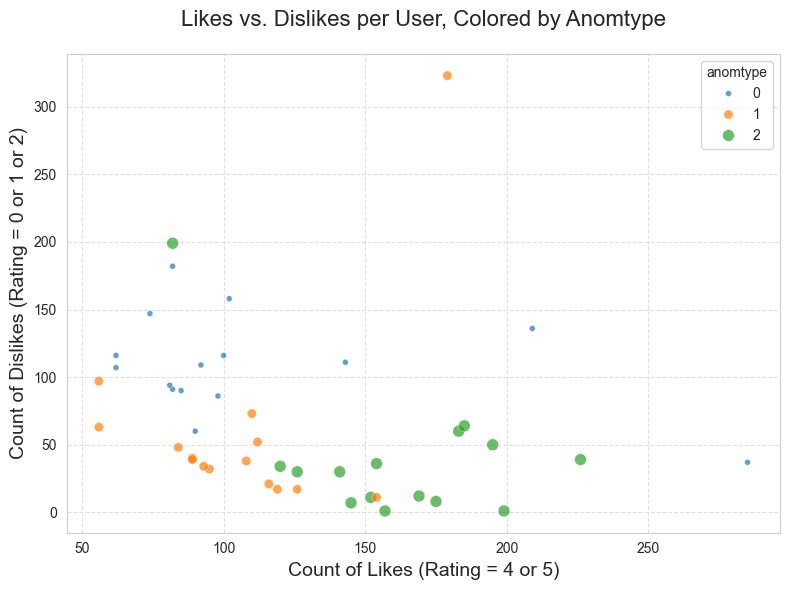

In [32]:
# Compute user-level counts
user_counts = X_no_dupes.groupby("user").agg(
    count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
    count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum())
)

# Merge with the target labels (y)
df_plot = pd.merge(user_counts.reset_index(), y_cat_combined, on="user")

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="count_like",
    y="count_dislike",
    hue="anomtype",  # Color points by the target label
    size="anomtype",  # Optional: vary point size by label for emphasis
    palette="tab10",  # Use a diverging color palette
    alpha=0.7,
)
plt.title("Likes vs. Dislikes per User, Colored by Anomtype", fontsize=16, pad=20)
plt.xlabel("Count of Likes (Rating = 4 or 5)", fontsize=14)
plt.ylabel("Count of Dislikes (Rating = 0 or 1 or 2)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Apart from a few outliers, it is easy to see that there are 3 main groups: 
1) Anomtype 0 in the middle/top left quadrant, with high number of dislikes and low number of likes
2) Anomtype 1 in the bottom left quadrant, with low number of both dislikes and likes
3) Anomtype 2 in the bottom right quadrant, with a high number of likes and low number of dislikes

This suggests that the balance between likes and dislikes is related to the label. We try to use weighted score to amplify the impact of these extremes to see if we can better distinguish the labels.

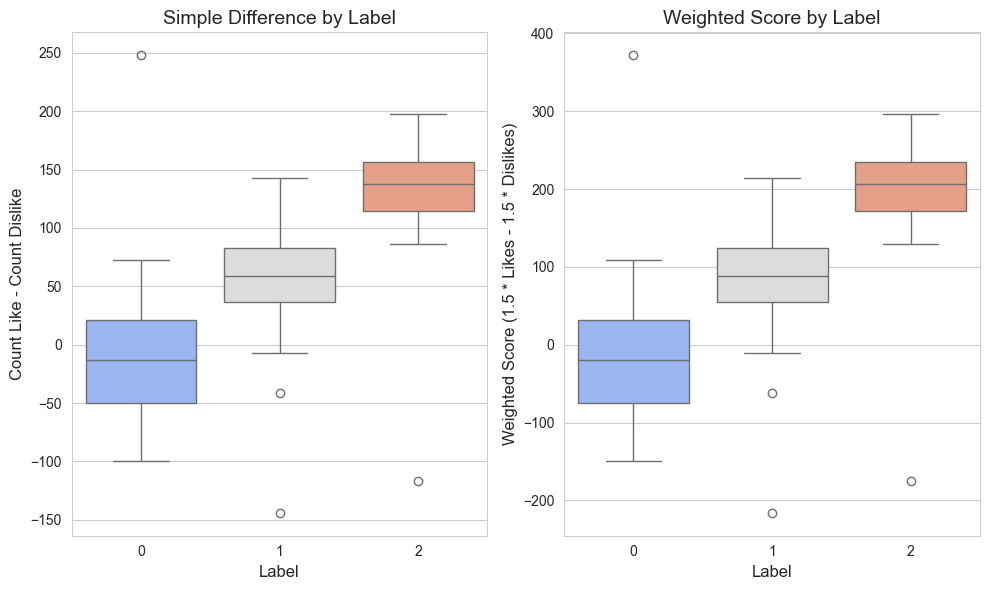

In [33]:
# Compute the simple difference and weighted score
df_plot["simple_diff"] = df_plot["count_like"] - df_plot["count_dislike"]
df_plot["weighted_score"] = df_plot["count_like"] * 1.5 - df_plot["count_dislike"] * 1.5

# Plot boxplots to compare
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="anomtype", y="simple_diff", data=df_plot, palette="coolwarm")
plt.title("Simple Difference by Label", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count Like - Count Dislike", fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x="anomtype", y="weighted_score", data=df_plot, palette="coolwarm")
plt.title("Weighted Score by Label", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Weighted Score (1.5 * Likes - 1.5 * Dislikes)", fontsize=12)

plt.tight_layout()
plt.show()

The two boxplots compare the distribution of user sentiment metrics across different label values. From the plot, we can see the y-axis from both plots have different ranges, due to one of them having the weighting factor. The weighted score plot on the right shows slightly better separation between labels, with less overlap in the IQR, which suggests that the weighting amplifies the differences in sentiment, making it a more discriminative feature for distinguishing between labels.

We could use this as a feature to try to enhance the ability to capture the polarity of user preferences.

### Creating Weighted Score Features

In [35]:
df_user_features["weighted_score"] = df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
df_user_features.head()

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score
user,,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772,-88.5
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701,-142.5
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107,309.0
3,3.801370,4.0,1.084853,35,50,207,292,0.708904,0.119863,0.171233,258.0
4,4.373737,4.0,0.713693,7,6,185,198,0.934343,0.035354,0.030303,267.0


### Distribution Features

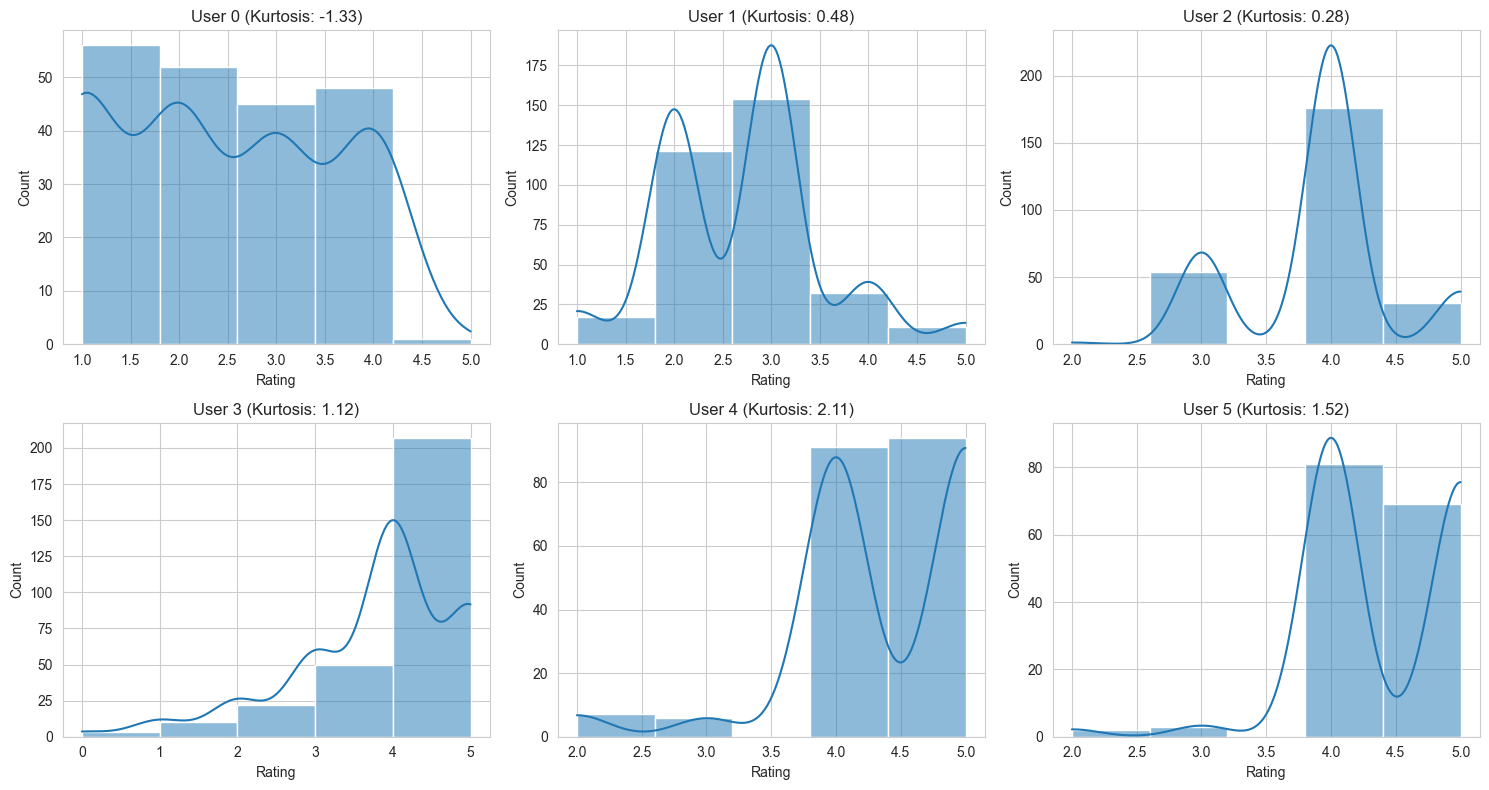

In [36]:
from scipy.stats import kurtosis

# Select a sample of users (e.g., first 6 users)
sample_users = X_no_dupes["user"].unique()[:6]

# Plot histograms of ratings for each user
plt.figure(figsize=(15, 8))
for i, user in enumerate(sample_users, 1):
    plt.subplot(2, 3, i)
    user_ratings = X_no_dupes[X_no_dupes["user"] == user]["rating"]
    sns.histplot(user_ratings, bins=5, kde=True)
    plt.title(f"User {user} (Kurtosis: {kurtosis(user_ratings):.2f})")
    plt.xlabel("Rating")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

Kurtosis is a statistical measure that describes the "tailedness" or shape of a distribution, particularly how much of the data is concentrated in the tails (extreme values) compared to the center. This feature captures the shape of a user’s rating distribution, which can reveal behavioral patterns that other features (like mean_rating or count_like) might miss.

Columns in df_kurtosis: Index(['user', 'rating_kurtosis'], dtype='object')
   user  rating_kurtosis
0     0        -1.329120
1     1         0.483190
2     2         0.281598
3     3         1.122078
4     4         2.109801


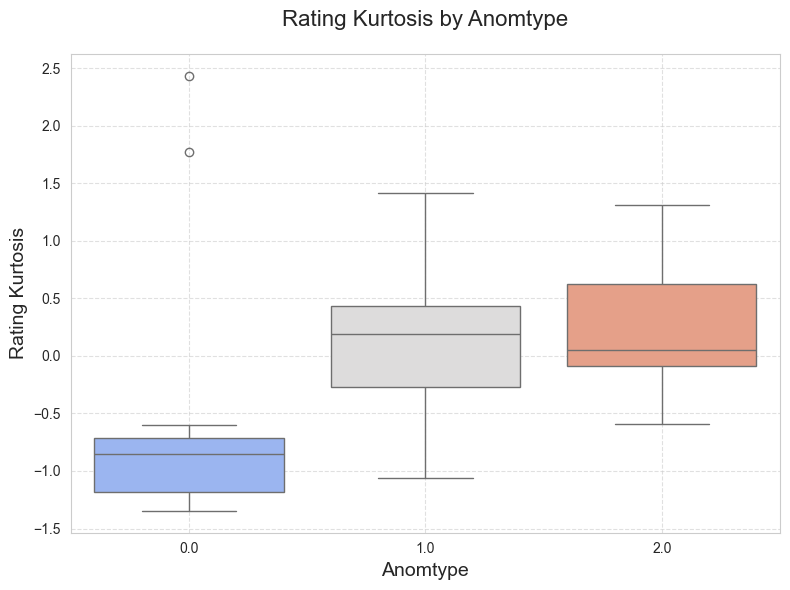

In [37]:
# Compute kurtosis for each user
user_kurtosis = X_no_dupes.groupby("user")["rating"].apply(lambda x: kurtosis(x)).fillna(0)

# Convert the Series to a DataFrame with the correct structure
df_kurtosis = pd.DataFrame({
    "user": user_kurtosis.index,
    "rating_kurtosis": user_kurtosis.values
})

# Verify the DataFrame
print("Columns in df_kurtosis:", df_kurtosis.columns)
print(df_kurtosis.head())

# Merge with the target labels (y)
df_plot = pd.merge(df_kurtosis, y_cat_combined, on="user", how="left")

# Create a boxplot of kurtosis by anomtype
plt.figure(figsize=(8, 6))
sns.boxplot(x="anomtype", y="rating_kurtosis", data=df_plot, palette="coolwarm")
plt.title("Rating Kurtosis by Anomtype", fontsize=16, pad=20)
plt.xlabel("Anomtype", fontsize=14)
plt.ylabel("Rating Kurtosis", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

It is quite clear that there are varying levels of Kurtosis for each different label (especially 0 vs 1 and 2), so this could also be a useful factor in increasing accuracy of our models.

### Creating Distribution Features

In [38]:
df_user_features["rating_kurtosis"] = X_no_dupes.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
)
df_user_features.head()

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis
user,,,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772,-88.5,-1.329120
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701,-142.5,0.483190
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107,309.0,0.281598
3,3.801370,4.0,1.084853,35,50,207,292,0.708904,0.119863,0.171233,258.0,1.122078
4,4.373737,4.0,0.713693,7,6,185,198,0.934343,0.035354,0.030303,267.0,2.109801


### Final feature engineering function

In [40]:
# Define the engineer_features function to add additional features

def engineer_features(df_X, df_y=None):
    df_X_no_dupes = df_X.drop_duplicates(subset=["user", "item"], keep="last")
    df_ratings = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
    all_items = range(0, 1000)
    df_ratings = df_ratings.reindex(columns=all_items, fill_value=-1)

    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
        count_neutral=("rating", lambda x: (x == 3).sum()),
        count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Fill NaN values in std_rating and rating_kurtosis
    df_user_features["std_rating"] = df_user_features["std_rating"].fillna(0)
    df_user_features["rating_kurtosis"] = df_user_features["rating_kurtosis"].fillna(0)

    final_df = pd.merge(df_ratings.reset_index(), df_user_features, on='user')
    
    if df_y is not None:
        df_merged = pd.merge(final_df.reset_index(), df_y, on="user", how="inner")
        return df_merged.drop(columns=["index"]).set_index("user")
    else:
        return final_df.set_index("user")


In [41]:
final_df = engineer_features(X_combined, y_combined)
display(final_df)

,0,1,2,3,4,5,6,7,8,9,...,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis,label
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,4.0,...,108,45,49,202,0.242574,0.534653,0.222772,-88.5,-1.329120,0.962817
1,-1.0,-1.0,2.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,-1.0,...,138,154,43,335,0.128358,0.411940,0.459701,-142.5,0.483190,0.031248
2,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1,54,207,262,0.790076,0.003817,0.206107,309.0,0.281598,0.068668
3,4.0,2.0,4.0,-1.0,1.0,3.0,-1.0,3.0,5.0,4.0,...,36,53,213,302,0.705298,0.119205,0.175497,265.5,1.077512,0.349012
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,...,7,6,329,342,0.961988,0.020468,0.017544,483.0,2.194315,0.917704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,-1.0,4.0,...,38,46,153,237,0.645570,0.160338,0.194093,172.5,0.029933,0.688060
2696,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,27,88,117,232,0.504310,0.116379,0.379310,135.0,0.837406,0.699900
2697,4.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,1.0,4.0,...,65,77,179,321,0.557632,0.202492,0.239875,171.0,-0.380813,0.308983
